# Purpose
- To re-create mfishtools in python (along with Hannah's code)
- Validate with inhibitory gene panel selection in R: no subsampling

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from importlib import reload

from mfishtoolspy import mfishtoolspy as mft


In [3]:
# options for cluster grouping
gene_panel_selection_ops = {
    'panel_name': 'inhibitory',
    'full_panel_size': 28,
    'starting_genes': ["Gad2","Slc17a7","Pvalb","Sst","Vip","Cck","Tac1","Npy","Crh","Necab1","Ptprt","Kirrel3","Penk","Hpse","Calb2","Chodl"],
    'layer_1234_filter': True,
    'use_supertypes': False,
    'blend_supertypes': False,
    'remove_bad_genes': False,
    'other_as_subclass': True,
}

# gene_panel_selection_ops = {
#     'panel_name': 'pan_neuronal',
#     'full_panel_size': 30,
#     'starting_genes': ["Gad2","Slc17a7","Tac2","Tac1","Calb1","Npy","Cck","Vip","Crh","Calb2","Penk","Oprm1","Pvalb","Ptprt","Kirrel3","Sst","Ndnf","Nos1","Baz1a","Sncg","Mybpc1","Lamp5","Hpse","Etv1","Rorb","Agmat","Chat","Adamts2"],
#     'layer_1234_filter': True,
#     'use_supertypes': False,
#     'blend_supertypes': True,
#     'remove_bad_genes': True,
#     'other_as_subclass': True,
# }

In [305]:
print(len(gene_panel_selection_ops['starting_genes']))

16


In [4]:
# paths to the data
data_folder = Path('//allen/programs/mindscope/workgroups/omfish/hannahs/mfish_project/gene_panels/L23_inh_panel/Mm_VISp_14236_20180912')
output_folder = Path('//allen/programs/mindscope/workgroups/learning/jinho/gene_panel_selection/inhibitory')

In [5]:
# read annotation
annotation = pd.read_feather(data_folder / 'anno.feather')

In [6]:
# read data (tasic 2018 v1)
data = pd.read_feather(data_folder / 'data_t.feather')
# Takes about 1 minute to run

In [15]:
data.set_index('gene', inplace=True, drop=True)
annotation.set_index('sample_id', inplace=True, drop=True)
assert np.all(annotation.index.values == data.columns.values)

In [16]:
# read supertype information
supertype_folder = Path('//allen/programs/mindscope/workgroups/omfish/hannahs/mfish_project/gene_panels')
supertype_fn = supertype_folder / 'tasic2018_supertypes_manual_v2.xlsx'
sheet_name = 'all_supertypes_v2'
supertype = pd.read_excel(supertype_fn, sheet_name=sheet_name)
supertype.rename(columns={'Cell Type': 'cell_type', 'Supertype': 'supertype'}, inplace=True)
supertype.cell_type = supertype.cell_type.str.replace('\xa0', ' ')
supertype.supertype = supertype.supertype.str.replace('\xa0', ' ')
assert np.all([ct in annotation['cluster_label'].values for ct in supertype.cell_type.values])
supertype.set_index('cell_type', inplace=True, drop=True)

annotation['supertype_label'] = annotation.cluster_label.map(supertype.supertype)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_29804\2809883879.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation['supertype_label'] = annotation.cluster_label.map(supertype.supertype)


In [17]:
# Preprocessing specific to match with Hannah's code
keep_class = ['GABAergic']
gabaergic_layer_threshold = 0.15
L6_layer_threshold = 0.75
L1234_labels = ['L1', 'L1-L2/3', 'L1-L4', 'L2/3', 'L2/3-L4', 'L4']
L6_labels = ['L5-L6', 'L6', 'L6b']

keep_types = []
if gene_panel_selection_ops['layer_1234_filter']:
    if 'Glutamatergic' in keep_class:
        L234_exc_subclasses = ['L2/3 IT','L4']
        L5_exc_subclasses = ['L5 IT','L5 PT','NP']
        L234_exc_types = annotation[annotation['subclass_label'].isin(L234_exc_subclasses)].cluster_label.unique()
        L5_exc_types = annotation[annotation['subclass_label'].isin(L5_exc_subclasses)].cluster_label.unique()
        keep_types.extend(L234_exc_types)
    if 'GABAergic' in keep_class:
        layer_df = annotation.query('class_label=="GABAergic"')[['layer_label', 'cluster_label']].copy()
        layer_table = layer_df.groupby(['layer_label', 'cluster_label']).size().unstack(fill_value=0)
        prop_table = layer_table.div(layer_table.sum(axis=0), axis=1)
        L1234_prop_sum = prop_table.loc[L1234_labels].sum(axis=0)
        L1234_inh_types = set(L1234_prop_sum[L1234_prop_sum >= gabaergic_layer_threshold].index.values)
        not_L1234_inh_types = set(layer_df.cluster_label).difference(L1234_inh_types)
        L6_prop_sum = prop_table.loc[L6_labels].sum(axis=0)
        L6_inh_types = set(L6_prop_sum[L6_prop_sum >= L6_layer_threshold].index.values)
        L5_inh_types = not_L1234_inh_types.difference(L6_inh_types)
        keep_types.extend(L1234_inh_types)
    
    # Check these codes later
    if gene_panel_selection_ops['other_as_subclass']:
        L5_inh_cluster_labels = []
        for cluster_label in L5_inh_types:
            temp_subclass = cluster_label.split(' ')[0]
            indices = annotation.query('cluster_label==@cluster_label').index
            annotation.loc[indices, 'cluster_label'] = f'L5 Inh {temp_subclass}' # need to change this code later. Don't reuse the same column name!
            L5_inh_cluster_labels.append(f'L5 Inh {temp_subclass}')
        L5_inh_cluster_labels = np.unique(L5_inh_cluster_labels)
        keep_types.extend(L5_inh_cluster_labels)
    else:
        keep_types.extend(L5_inh_types)
    
    # Check these codes later
    if gene_panel_selection_ops['use_supertypes']:
        keep_clusts = annotation.query('cluster_label in @keep_types').supertype_label.unique()
        L5_inh_types = annotation.query('cluster_label in @L5_inh_types').L5_inh_types.unique()
        annotation['cluster_label_original'] = annotation['cluster_label']
        annotation['cluster_label'] = annotation['supertype_label']
        annotation.query('cluster_label_original in @L5_inh_cluster_labels')['cluster_label'] = \
            annotation.query('cluster_label_original in @L5_inh_cluster_labels')['cluster_label_original']
    else:
        keep_clusts = annotation.query('cluster_label in @keep_types').cluster_label.unique()
    


In [19]:
# keep_clusts is the same between python and R
np.sort(keep_clusts)

array(['L5 Inh Pvalb', 'L5 Inh Serpinf1', 'L5 Inh Sst', 'L5 Inh Vip',
       'Lamp5 Fam19a1 Pax6', 'Lamp5 Fam19a1 Tmem182', 'Lamp5 Krt73',
       'Lamp5 Lhx6', 'Lamp5 Lsp1', 'Lamp5 Ntn1 Npy2r',
       'Lamp5 Plch2 Dock5', 'Pvalb Reln Itm2a', 'Pvalb Tpbg',
       'Pvalb Vipr2', 'Serpinf1 Aqp5 Vip', 'Sncg Gpr50', 'Sncg Slc17a8',
       'Sncg Vip Itih5', 'Sncg Vip Nptx2', 'Sst Calb2 Necab1',
       'Sst Calb2 Pdlim5', 'Sst Chodl', 'Sst Hpse Cbln4',
       'Sst Hpse Sema3c', 'Sst Mme Fam114a1', 'Sst Tac1 Htr1d',
       'Sst Tac1 Tacr3', 'Vip Arhgap36 Hmcn1', 'Vip Chat Htr1f',
       'Vip Col15a1 Pde1a', 'Vip Crispld2 Htr2c', 'Vip Crispld2 Kcne4',
       'Vip Igfbp4 Mab21l1', 'Vip Igfbp6 Car10', 'Vip Igfbp6 Pltp',
       'Vip Lect1 Oxtr', 'Vip Lmo1 Myl1', 'Vip Ptprt Pkp2',
       'Vip Pygm C1ql1', 'Vip Rspo1 Itga4', 'Vip Rspo4 Rxfp1 Chat'],
      dtype=object)

In [20]:
# remove starting genes that are not in the data
st_in_data = [st not in data.index.values for st in gene_panel_selection_ops['starting_genes']]
if np.any(st_in_data):
    st_not_in_data = [st for i, st in enumerate(gene_panel_selection_ops['starting_genes']) if st_in_data[i]]
    print(f'{st_not_in_data} are not in the data')
    gene_panel_selection_ops['starting_genes'] = [st for st in gene_panel_selection_ops['starting_genes'] if st not in st_not_in_data]

In [307]:
print(len(gene_panel_selection_ops['starting_genes']))

16


In [21]:
# Convert cpm data to log2
data_log2 = np.log2(data + 1)
# takes about 9 s to run

In [23]:
# calculate proportions and medians per cluster
cluster_names = annotation.cluster_label.unique()
expr_thresh = 1
# make data_log2 to have another level of columns with matching cluster names per cell ID
data_log2_cluster = data_log2.copy().T
assert np.all(data_log2.columns == annotation.index.values)
# groupby cluster and calculate median and proportion
data_log2_cluster['cluster_label'] = annotation['cluster_label']
median_per_cluster = data_log2_cluster.groupby('cluster_label').median().T
prop_expr = data_log2_cluster.groupby('cluster_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
assert np.all(prop_expr.index.values == median_per_cluster.index.values)
assert np.all(prop_expr.index.values == data_log2.index.values)



In [24]:
# Compare with R results
prop_expr_r_fn = output_folder / 'prop_expr_tmp_R.csv'
median_per_cluster_r_fn = output_folder / 'median_expr_tmp_R.csv'
prop_expr_r = pd.read_csv(prop_expr_r_fn, index_col=0)
median_per_cluster_r = pd.read_csv(median_per_cluster_r_fn, index_col=0)

In [25]:
prop_expr.head()

cluster_label,Astro Aqp4,CR Lhx5,Endo Ctla2a,Endo Cytl1,L2/3 IT VISp Adamts2,L2/3 IT VISp Agmat,L2/3 IT VISp Rrad,L4 IT VISp Rspo1,L5 IT VISp Batf3,L5 IT VISp Col27a1,...,Vip Crispld2 Kcne4,Vip Igfbp4 Mab21l1,Vip Igfbp6 Car10,Vip Igfbp6 Pltp,Vip Lect1 Oxtr,Vip Lmo1 Myl1,Vip Ptprt Pkp2,Vip Pygm C1ql1,Vip Rspo1 Itga4,Vip Rspo4 Rxfp1 Chat
gene,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.111413,0.000000,0.000000,0.00,0.038278,0.021021,0.000000,0.008565,0.009302,0.000000,...,0.000000,0.051724,0.000000,0.008130,0.000000,0.014706,0.000000,0.015152,0.02,0.029851
0610006L08Rik,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.009434,0.000714,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
0610007P14Rik,0.453804,0.571429,0.300000,0.25,0.990431,0.986486,0.971698,0.904354,0.967442,1.000000,...,0.845455,0.862069,0.830986,0.829268,0.869565,0.897059,0.895238,0.893939,0.80,0.880597
0610009B22Rik,0.491848,0.428571,0.244444,0.00,0.947368,0.962462,0.688679,0.800857,0.974419,0.991453,...,0.845455,0.724138,0.732394,0.731707,0.834783,0.955882,0.861905,0.871212,0.74,0.716418
0610009E02Rik,0.038043,0.142857,0.011111,0.00,0.105263,0.093093,0.160377,0.051392,0.076744,0.042735,...,0.081818,0.034483,0.014085,0.056911,0.052174,0.058824,0.066667,0.045455,0.02,0.119403


In [26]:
prop_expr_r = prop_expr_r[prop_expr.columns]
prop_expr_r.head()

,Astro Aqp4,CR Lhx5,Endo Ctla2a,Endo Cytl1,L2/3 IT VISp Adamts2,L2/3 IT VISp Agmat,L2/3 IT VISp Rrad,L4 IT VISp Rspo1,L5 IT VISp Batf3,L5 IT VISp Col27a1,...,Vip Crispld2 Kcne4,Vip Igfbp4 Mab21l1,Vip Igfbp6 Car10,Vip Igfbp6 Pltp,Vip Lect1 Oxtr,Vip Lmo1 Myl1,Vip Ptprt Pkp2,Vip Pygm C1ql1,Vip Rspo1 Itga4,Vip Rspo4 Rxfp1 Chat
0610005C13Rik,0.111413,0.000000,0.000000,0.00,0.038278,0.021021,0.000000,0.008565,0.009302,0.000000,...,0.000000,0.051724,0.000000,0.008130,0.000000,0.014706,0.000000,0.015152,0.02,0.029851
0610006L08Rik,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.009434,0.000714,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
0610007P14Rik,0.453804,0.571429,0.300000,0.25,0.990431,0.986486,0.971698,0.904354,0.967442,1.000000,...,0.845455,0.862069,0.830986,0.829268,0.869565,0.897059,0.895238,0.893939,0.80,0.880597
0610009B22Rik,0.491848,0.428571,0.244444,0.00,0.947368,0.962462,0.688679,0.800857,0.974419,0.991453,...,0.845455,0.724138,0.732394,0.731707,0.834783,0.955882,0.861905,0.871212,0.74,0.716418
0610009E02Rik,0.038043,0.142857,0.011111,0.00,0.105263,0.093093,0.160377,0.051392,0.076744,0.042735,...,0.081818,0.034483,0.014085,0.056911,0.052174,0.058824,0.066667,0.045455,0.02,0.119403


In [27]:
np.max(np.abs(prop_expr - prop_expr_r))

5.551115123125783e-16

In [28]:
median_per_cluster.head()

cluster_label,Astro Aqp4,CR Lhx5,Endo Ctla2a,Endo Cytl1,L2/3 IT VISp Adamts2,L2/3 IT VISp Agmat,L2/3 IT VISp Rrad,L4 IT VISp Rspo1,L5 IT VISp Batf3,L5 IT VISp Col27a1,...,Vip Crispld2 Kcne4,Vip Igfbp4 Mab21l1,Vip Igfbp6 Car10,Vip Igfbp6 Pltp,Vip Lect1 Oxtr,Vip Lmo1 Myl1,Vip Ptprt Pkp2,Vip Pygm C1ql1,Vip Rspo1 Itga4,Vip Rspo4 Rxfp1 Chat
gene,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610006L08Rik,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610007P14Rik,0.000000,6.247789,0.0,0.0,6.914645,6.657416,6.141694,6.418927,6.173059,6.312999,...,5.870013,6.374446,6.279457,6.552380,6.466378,6.474331,6.894218,6.418571,6.642808,6.875275
0610009B22Rik,0.814706,0.000000,0.0,0.0,5.769752,6.076098,4.468977,5.788960,5.990343,6.339431,...,5.918368,6.000401,5.269012,5.617239,6.258903,6.428014,6.458077,5.990274,6.165060,6.249834
0610009E02Rik,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
# order median_per_cluster_r by the column name order of median_per_cluster
median_per_cluster_r = median_per_cluster_r[median_per_cluster.columns]
median_per_cluster_r.head()

,Astro Aqp4,CR Lhx5,Endo Ctla2a,Endo Cytl1,L2/3 IT VISp Adamts2,L2/3 IT VISp Agmat,L2/3 IT VISp Rrad,L4 IT VISp Rspo1,L5 IT VISp Batf3,L5 IT VISp Col27a1,...,Vip Crispld2 Kcne4,Vip Igfbp4 Mab21l1,Vip Igfbp6 Car10,Vip Igfbp6 Pltp,Vip Lect1 Oxtr,Vip Lmo1 Myl1,Vip Ptprt Pkp2,Vip Pygm C1ql1,Vip Rspo1 Itga4,Vip Rspo4 Rxfp1 Chat
0610005C13Rik,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610006L08Rik,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610007P14Rik,0.000000,6.247789,0.0,0.0,6.914645,6.657416,6.141694,6.418927,6.173059,6.312999,...,5.870013,6.374446,6.279457,6.552380,6.466378,6.474331,6.894218,6.418571,6.642808,6.875275
0610009B22Rik,0.814706,0.000000,0.0,0.0,5.769752,6.076098,4.468977,5.788960,5.990343,6.339431,...,5.918368,6.000401,5.269012,5.617239,6.258903,6.428014,6.458077,5.990274,6.165060,6.249834
0610009E02Rik,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
np.max(np.abs(median_per_cluster.values - median_per_cluster_r.values))

4.973799150320701e-14

## median and propexpr correct
- Now go into the filter panel function

In [41]:
reload(mft)

<module 'mfishtoolspy.mfishtoolspy' from 'c:\\users\\jinho.kim\\github\\mfishtoolspy\\mfishtoolspy\\mfishtoolspy.py'>

In [42]:

run_genes, keep_genes, filtered_out_genes  = mft.filter_panel_genes(2**median_per_cluster - 1, 
prop_expr=prop_expr,
on_clusters=list(keep_clusts),
off_clusters=list(annotation.query('class_label=="Non-Neuronal"').cluster_label.unique()),
starting_genes=gene_panel_selection_ops['starting_genes'],
num_binary_genes=300,
min_on=10,
max_on=5000,
max_off=10,
min_length=1400,
max_fraction_on_clusters=0.5,
exclude_families=["LOC","Fam","RIK","RPS","RPL","\\-","Gm","Rnf","BC0"])

1297 total genes pass constraints prior to binary score calculation.


In [43]:
len(keep_genes)

45768

In [34]:
run_genes_r_fn = output_folder / 'run_genes_tmp_inh_R.csv'
run_genes_r = pd.read_csv(run_genes_r_fn, index_col=0)
run_genes_r = run_genes_r.index.values

In [37]:
len(run_genes_r)

313

In [44]:
set(run_genes_r) - set(run_genes)

{'AF529169',
 'Adamts15',
 'Alk',
 'Arid5a',
 'Cd55',
 'Clrn1',
 'Colgalt2',
 'Dennd2d',
 'Dgki',
 'Epb4.1',
 'Kcna3',
 'Lrrc55',
 'March11',
 'Nxph3',
 'Pcnxl2',
 'Ptk2b',
 'Scgn',
 'Sh3kbp1',
 'Slc10a4',
 'Slc13a1',
 'Slc35d3',
 'Slc35f3',
 'Sln',
 'Snx31',
 'St3gal1',
 'Strip2',
 'Syt17',
 'Tcrb',
 'Tmem132d',
 'Tmtc4',
 'Tnfrsf12a',
 'Trpc4',
 'Vav2',
 'Zfp57'}

# Up until gene filtering is working correctly


## Archive

## Testing keep_genes, on_clusters, and beta_Scores

In [40]:
genes = median_per_cluster.index
keep_genes_df = pd.DataFrame({'keep':keep_genes}, index=genes)
# keep_genes_df.to_csv(output_folder / 'keep_genes_python.csv')

NameError: name 'keep_genes' is not defined

In [226]:
keep_genes_df

,keep
gene,
0610005C13Rik,False
0610006L08Rik,False
0610007P14Rik,False
0610009B22Rik,False
0610009E02Rik,False
...,...
n-R5s142,False
n-R5s143,False
n-R5s144,False


In [227]:
keep_genes_r = pd.read_csv(output_folder / 'keepGenes_tmp_inh_R.csv')
keep_genes_r.rename(columns={'Unnamed: 0':'gene', 'x': 'keep_r'}, inplace=True)
keep_genes_r.set_index('gene', inplace=True, drop=True)

In [76]:
keep_genes_r

,keep
gene,
0610005C13Rik,False
0610006L08Rik,False
0610007P14Rik,False
0610009B22Rik,False
0610009E02Rik,False
...,...
n-R5s142,False
n-R5s143,False
n-R5s144,False


In [81]:
np.all(keep_genes_r.index == keep_genes_df.index)

np.True_

In [88]:
keep_genes_merged = keep_genes_r.merge(keep_genes_df, left_index=True, right_index=True, how='inner')

In [198]:
keep_genes_merged

,keep_r,keep
gene,,
0610005C13Rik,False,False
0610006L08Rik,False,False
0610007P14Rik,False,False
0610009B22Rik,False,False
0610009E02Rik,False,False
...,...,...
n-R5s142,False,False
n-R5s143,False,False
n-R5s144,False,False


In [89]:
np.where(keep_genes_merged.keep.values != keep_genes_merged.keep_r.values)

(array([], dtype=int64),)

In [108]:
np.equal(keep_genes_df.values, keep_genes_r.values).all()

np.True_

## Up until keep_genes are the same.
- So the problem is in beta score calculation

In [222]:
reload(mfishtools)
top_beta_scores = mfishtools.get_beta_score(prop_expr.loc[keep_genes, on_clusters], True)
top_beta = mfishtools.get_beta_score(prop_expr.loc[keep_genes, on_clusters], False)

In [204]:
top_beta_scores

array([0.30172815, 0.41207792, 0.31311229, ..., 0.2486012 , 0.20080129,
       0.24901571])

In [211]:
top_beta_scores_r = pd.read_csv(output_folder / 'topBeta_scores_tmp_inh_R.csv', index_col=0)
top_beta_r = pd.read_csv(output_folder / 'topBeta_tmp_inh_R.csv', index_col=0)

In [223]:
top_beta

array([ 619.,  287.,  571., ...,  941., 1210.,  936.])

In [213]:
top_beta_r

,x
AA414768,619
AF529169,287
AK129341,571
AU022252,690
AU041133,1148
...,...
Zkscan14,926
Znhit6,1043
Zpbp,941
Zscan18,1210


In [214]:
np.max(np.abs(top_beta_scores_r.x.values - top_beta_scores))

np.float64(1.2503331703328513e-12)

In [210]:
np.argsort(-top_beta_scores)

array([378, 680, 934, ..., 631,  78, 863])

In [215]:
from scipy.stats import rankdata
rankdata(-top_beta_scores)

array([ 619.,  287.,  571., ...,  941., 1210.,  936.])

# Testing gene panel building now

In [240]:
keep_sampled_cells = annotation.query('cluster_label in @keep_clusts').index.values


In [242]:
gene_panel_selection_ops['starting_genes']

['Gad2',
 'Slc17a7',
 'Pvalb',
 'Sst',
 'Vip',
 'Cck',
 'Tac1',
 'Npy',
 'Crh',
 'Necab1',
 'Ptprt',
 'Kirrel3',
 'Penk',
 'Hpse',
 'Calb2',
 'Chodl']

In [244]:
data_log2.head()

,LS-14690_S02_E1-50,LS-14690_S03_E1-50,LS-14690_S05_E1-50,LS-14690_S06_E1-50,LS-14690_S07_E1-50,LS-14690_S08_E1-50,LS-14690_S09_E1-50,LS-14690_S10_E1-50,LS-14690_S11_E1-50,LS-14690_S12_E1-50,...,SQ-80004_S37_E1-50,SQ-80004_S38_E1-50,SQ-80004_S39_E1-50,SQ-80004_S40_E1-50,SQ-80004_S41_E1-50,SQ-80004_S42_E1-50,SQ-80004_S43_E1-50,SQ-80004_S44_E1-50,SQ-80004_S47_E1-50,SQ-80004_S48_E1-50
gene,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000
0610006L08Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000
0610007P14Rik,5.469228,3.604938,5.018023,7.199591,7.278554,0.000000,0.000000,6.409122,6.054598,3.611957,...,7.690435,7.521213,0.000000,6.002811,6.710045,0.00000,8.416247,6.652820,0.0,7.063134
0610009B22Rik,6.996524,5.804930,4.366421,4.150003,6.698230,5.586872,5.953174,6.839418,4.402186,6.364453,...,3.328024,0.000000,6.301733,6.263860,6.186886,0.52563,0.000000,4.687687,0.0,7.199262
0610009E02Rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.680615,0.000000,0.000000,2.832697,2.560461,0.00000,0.000000,0.000000,0.0,2.324765


In [247]:
median_per_cluster.loc[run_genes, keep_clusts]

cluster_label,Pvalb Tpbg,Vip Chat Htr1f,Lamp5 Lsp1,Sst Hpse Sema3c,Vip Pygm C1ql1,Vip Ptprt Pkp2,Vip Igfbp4 Mab21l1,Sst Chodl,Lamp5 Ntn1 Npy2r,Vip Igfbp6 Car10,...,L5 Inh Serpinf1,Sst Calb2 Pdlim5,Sst Mme Fam114a1,Sst Hpse Cbln4,Vip Lect1 Oxtr,Sst Tac1 Htr1d,Sncg Gpr50,Vip Rspo1 Itga4,Sst Tac1 Tacr3,Sst Calb2 Necab1
gene,,,,,,,,,,,,,,,,,,,,,
AF529169,0.712634,0.0,0.000000,4.146556,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.817983,3.665581,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Adamts15,3.830336,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Adamts16,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,3.670036,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.750859,0.0,0.000000,0.000000
Adamts3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,4.745453,0.000000,0.000000,...,2.864508,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
Adamts8,4.802122,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Whrn,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.306571,0.276881,0.000000,0.0,4.335578,5.529276,0.0,1.829491,5.022902
Wif1,1.450424,0.0,5.402413,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.594328,0.0,0.000000,0.000000
Wipf3,5.313643,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,5.307768,4.741393,4.682528,3.753302,0.0,4.837751,0.000000,0.0,6.278412,3.873824


In [386]:
reload(mfishtools)
built_panel = mfishtools.build_mapping_based_marker_panel(
                map_data=data_log2.loc[run_genes, keep_sampled_cells].copy(),
                median_data=median_per_cluster.loc[run_genes, keep_clusts].copy(),
                cluster_call=annotation.loc[keep_sampled_cells, 'cluster_label'].copy(),
                panel_size=gene_panel_selection_ops['full_panel_size'],
                current_panel=gene_panel_selection_ops['starting_genes'].copy(),
                num_subsample=None,
                panel_min=3, # should not affect
                # optimize='correlation_distance',
                optimize='fraction_correct',
)
# Takes 7 minutes and 17 seconds to run (pan-inhibitory)
# Takes 6 minutes and 46 seconds to run after indexing cluster_label map
# Takes 7 minutes and 39 seconds after removing cluster_distance re-calculation (weird...)
# Takes 7 minutes and 17 seconds after flattening cluster_distance dataframe. (revert back for readability)

# Leave the cluster_distance as dataframe, as it is easier to read

Added Nkain3 with 0.662, now matching [16].
Added Oprm1 with 0.685, now matching [17].
Added Htr1f with 0.701, now matching [18].
Added Il1rapl2 with 0.713, now matching [19].
Added Tpbg with 0.723, now matching [20].
Added Ngf with 0.731, now matching [21].
Added Fibcd1 with 0.739, now matching [22].
Added Cpne4 with 0.745, now matching [23].
Added Sfrp2 with 0.750, now matching [24].
Added Grm8 with 0.755, now matching [25].
Added Pfkfb3 with 0.761, now matching [26].
Added Tox with 0.764, now matching [27].


# All works fine, validated with both fraction_correct and correlation_distance

In [393]:
annotation.loc[keep_sampled_cells, 'cluster_label'].copy()

sample_id
LS-14690_S02_E1-50         Pvalb Tpbg
LS-14690_S10_E1-50     Vip Chat Htr1f
LS-14690_S16_E1-50         Lamp5 Lsp1
LS-14690_S18_E1-50    Sst Hpse Sema3c
LS-14690_S19_E1-50     Vip Pygm C1ql1
                           ...       
SQ-80001_S32_E1-50        Pvalb Vipr2
SQ-80004_S36_E1-50     Vip Chat Htr1f
SQ-80004_S40_E1-50        Pvalb Vipr2
SQ-80004_S41_E1-50         Lamp5 Lsp1
SQ-80004_S48_E1-50      Vip Lmo1 Myl1
Name: cluster_label, Length: 5613, dtype: object

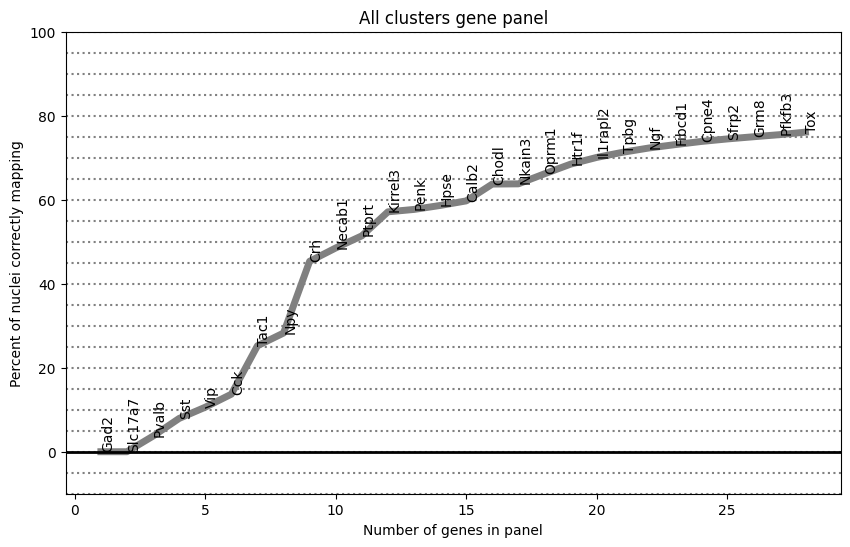

In [398]:
reload(mfishtools)
fig, ax = plt.subplots(figsize=(10,6))
frac, ax = mfishtools.fraction_correct_with_genes(built_panel, 
                map_data=data_log2.loc[run_genes, keep_sampled_cells].copy(),
                median_data=median_per_cluster.loc[run_genes, keep_clusts].copy(),
                cluster_call=annotation.loc[keep_sampled_cells, 'cluster_label'].copy(),
                ax=ax)

In [399]:
corr_matrix_df = mfishtools.cor_tree_mapping(map_data=data_log2.loc[:, keep_sampled_cells],
median_data=median_per_cluster.loc[:, keep_clusts],
genes_to_map=built_panel)
assigned_cluster = mfishtools.get_top_match(corr_matrix_df)

In [406]:
reload(mfishtools)
confusion_matrix = mfishtools.get_confusion_matrix(annotation.loc[keep_sampled_cells, 'cluster_label'].values,
assigned_cluster.TopLeaf.values)

In [407]:
confusion_matrix

Real,L5 Inh Pvalb,L5 Inh Serpinf1,L5 Inh Sst,L5 Inh Vip,Lamp5 Fam19a1 Pax6,Lamp5 Fam19a1 Tmem182,Lamp5 Krt73,Lamp5 Lhx6,Lamp5 Lsp1,Lamp5 Ntn1 Npy2r,...,Vip Crispld2 Kcne4,Vip Igfbp4 Mab21l1,Vip Igfbp6 Car10,Vip Igfbp6 Pltp,Vip Lect1 Oxtr,Vip Lmo1 Myl1,Vip Ptprt Pkp2,Vip Pygm C1ql1,Vip Rspo1 Itga4,Vip Rspo4 Rxfp1 Chat
Predicted,,,,,,,,,,,,,,,,,,,,,
L5 Inh Pvalb,0.811224,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
L5 Inh Serpinf1,0.000000,0.6,0.005727,0.000000,0.046512,0.000000,0.048780,0.000000,0.004444,0.005435,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
L5 Inh Sst,0.003401,0.0,0.916380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
L5 Inh Vip,0.000000,0.0,0.000000,0.461039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009091,0.017241,0.014085,0.016260,0.000000,0.044118,0.061905,0.015152,0.00,0.134328
Lamp5 Fam19a1 Pax6,0.000000,0.0,0.000000,0.000000,0.697674,0.195652,0.146341,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
Lamp5 Fam19a1 Tmem182,0.000000,0.0,0.000000,0.000000,0.069767,0.695652,0.073171,0.000000,0.002222,0.065217,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
Lamp5 Krt73,0.000000,0.0,0.000000,0.000000,0.116279,0.000000,0.731707,0.000000,0.006667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
Lamp5 Lhx6,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.956522,0.024444,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
Lamp5 Lsp1,0.000000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.897778,0.005435,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


In [409]:
confusion_matrix.columns.name

'Real'

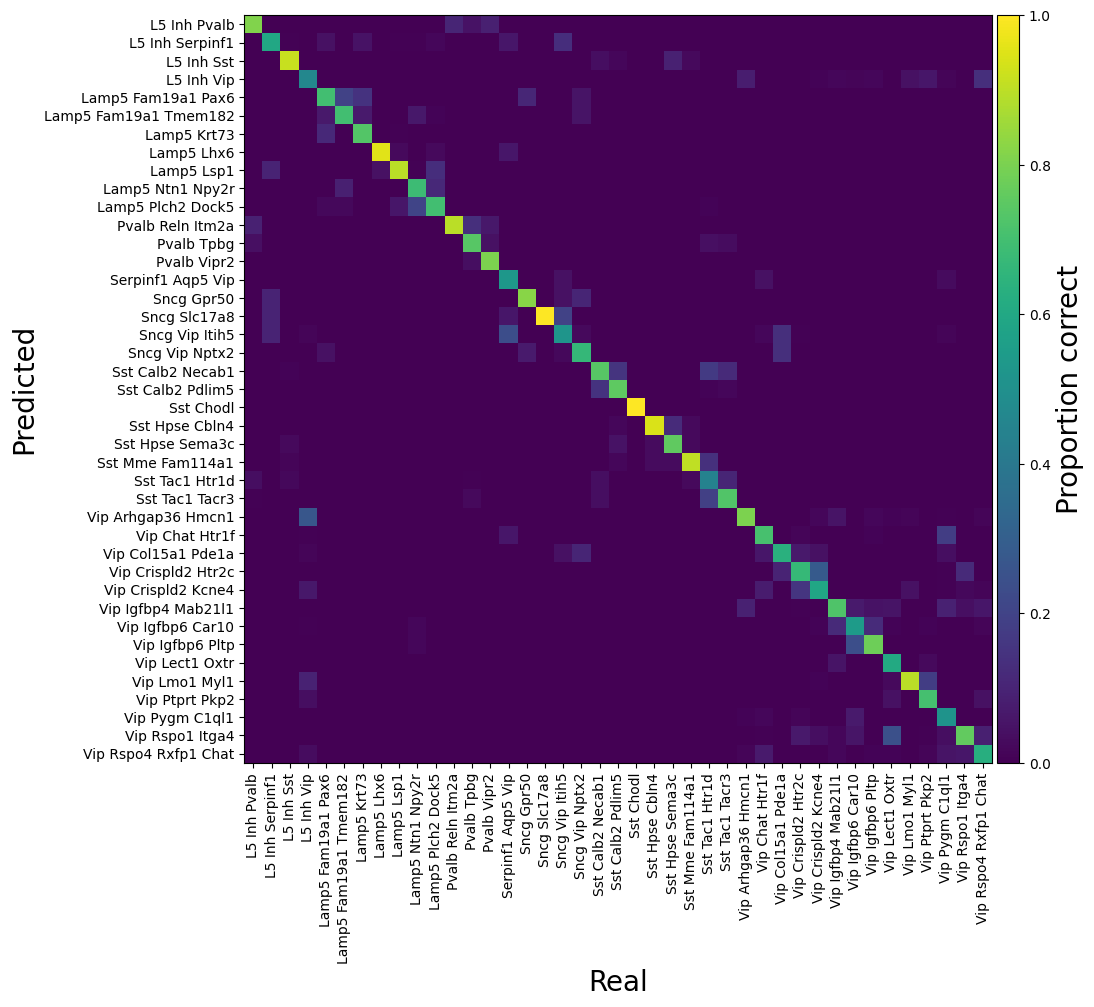

In [422]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(confusion_matrix)
# add colorbar to the right, with the same height as the image
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Proportion correct', fontsize=20)

# fig.colorbar(im, ax=ax, label='Proportion correct')
ax.set_xlabel(confusion_matrix.columns.name, fontsize=20)
ax.set_ylabel(confusion_matrix.index.name, fontsize=20)
ax.set_xticks(range(len(confusion_matrix.columns)))
ax.set_yticks(range(len(confusion_matrix.index)))
ax.set_xticklabels(confusion_matrix.columns, rotation=90)
ax.set_yticklabels(confusion_matrix.index);


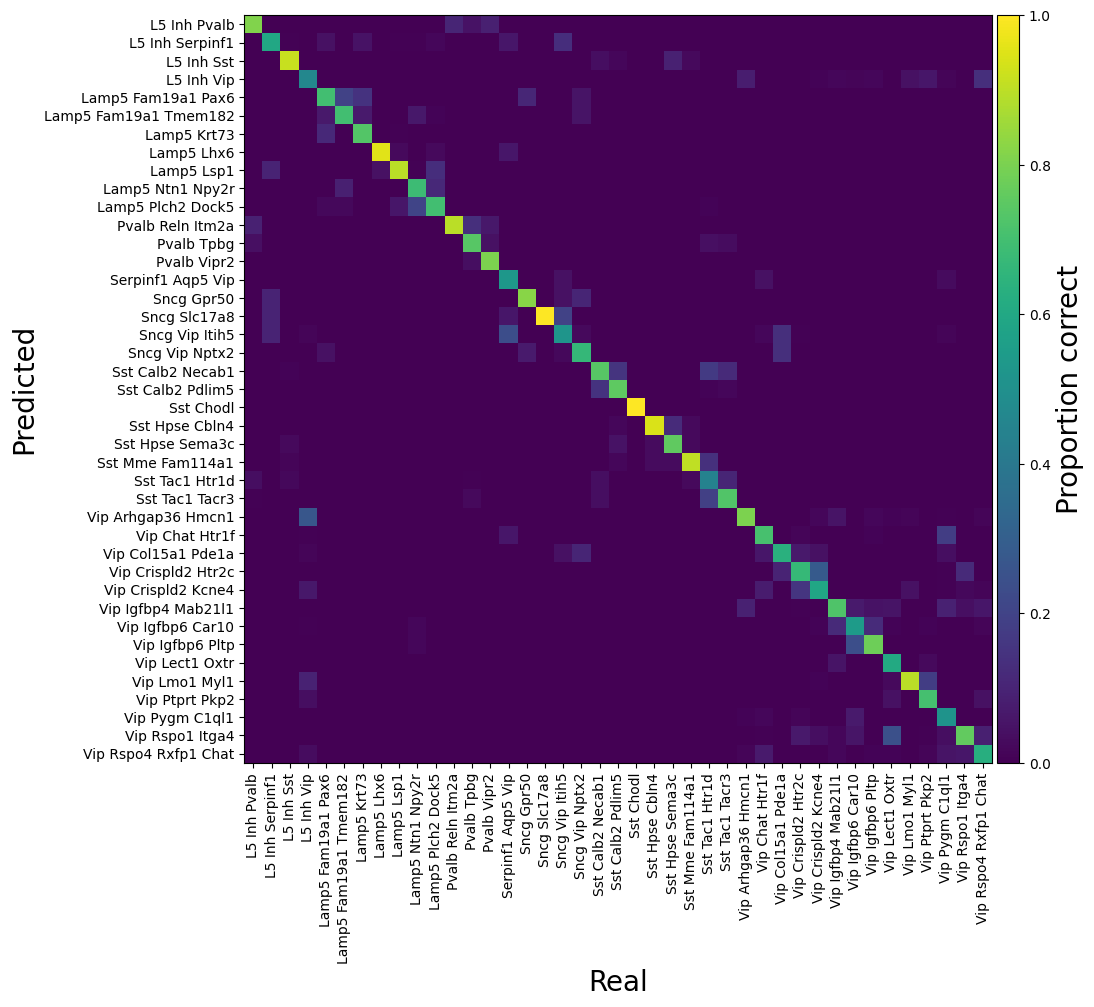

In [425]:
reload(mfishtools)
ax = mfishtools.plot_confusion_matrix(confusion_matrix)

# Archive

## Debug build_mapping_based_marker_panel
- both the gene and cluster distance are different

In [264]:
# check the input data
map_data_r_fn = output_folder / 'mapDat_tmp_inh_R.csv'
map_data_r = pd.read_csv(map_data_r_fn, index_col=0)
median_data_r_fn = output_folder / 'medianDat_tmp_inh_R.csv'
median_data_r = pd.read_csv(median_data_r_fn, index_col=0)
cluster_call_r_fn = output_folder / 'clustersF_tmp_inh_R.csv'
cluster_call_r = pd.read_csv(cluster_call_r_fn, index_col=0)

In [314]:
map_data = data_log2.loc[run_genes, keep_sampled_cells].copy()
assert np.all(map_data_r.columns == map_data.columns)
assert set(map_data_r.index) == set(map_data.index)
map_data_r = map_data_r.loc[map_data.index, map_data.columns]

In [266]:
data_log2.loc[run_genes, keep_sampled_cells].head()

,LS-14690_S02_E1-50,LS-14690_S10_E1-50,LS-14690_S16_E1-50,LS-14690_S18_E1-50,LS-14690_S19_E1-50,LS-14690_S21_E1-50,LS-14690_S22_E1-50,LS-14690_S23_E1-50,LS-14690_S24_E1-50,LS-14690_S25_E1-50,...,SQ-80001_S04_E1-50,SQ-80001_S10_E1-50,SQ-80001_S11_E1-50,SQ-80001_S15_E1-50,SQ-80001_S16_E1-50,SQ-80001_S32_E1-50,SQ-80004_S36_E1-50,SQ-80004_S40_E1-50,SQ-80004_S41_E1-50,SQ-80004_S48_E1-50
gene,,,,,,,,,,,,,,,,,,,,,
AF529169,3.703513,0.0,1.744393,6.121439,0.0,2.257879,0.0,4.951544,0.0,0.000000,...,2.424975,0.0,0.000000,5.027726,0.0,1.762967,0.000000,0.000000,0.00000,5.826213
Adamts15,4.938680,0.0,3.143251,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.564418,0.000000,0.000000,0.00000,0.000000
Adamts16,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,5.414789,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
Adamts3,0.000000,0.0,4.519691,0.000000,0.0,2.654442,0.0,2.042319,0.0,7.259525,...,3.946885,0.0,5.797091,0.000000,0.0,0.000000,2.463441,0.000000,5.28418,0.000000
Adamts8,3.789684,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,5.938020,0.0,0.000000,2.326352,0.0,0.000000,0.000000,0.556876,0.00000,0.000000


In [272]:
np.max(np.abs(map_data_r.values - map_data.values))

np.float64(4.973799150320701e-14)

In [313]:
median_data = median_per_cluster.loc[run_genes, keep_clusts].copy()
assert set(median_data.columns) == set(median_data_r.columns)
assert set(median_data.index) == set(median_data_r.index)
median_data_r = median_data_r.loc[median_data.index, median_data.columns]

In [278]:
np.max(np.abs(median_data_r.values - median_data.values))

np.float64(4.973799150320701e-14)

In [279]:
cluster_call_r.head()

,x
LS-14690_S02_E1-50,Pvalb Tpbg
LS-14690_S10_E1-50,Vip Chat Htr1f
LS-14690_S16_E1-50,Lamp5 Lsp1
LS-14690_S18_E1-50,Sst Hpse Sema3c
LS-14690_S19_E1-50,Vip Pygm C1ql1


In [280]:
cluster_call = annotation.loc[keep_sampled_cells, 'cluster_label']
cluster_call.head()

sample_id
LS-14690_S02_E1-50         Pvalb Tpbg
LS-14690_S10_E1-50     Vip Chat Htr1f
LS-14690_S16_E1-50         Lamp5 Lsp1
LS-14690_S18_E1-50    Sst Hpse Sema3c
LS-14690_S19_E1-50     Vip Pygm C1ql1
Name: cluster_label, dtype: object

In [287]:
assert np.all(cluster_call_r.index == cluster_call.index)
assert np.all(cluster_call_r.values.flatten() == cluster_call.values)

## All the inputs are the same
- Now go into the function (build_mapping_based_marker_panel)

In [362]:
# cluster_distance calculation
cor_dist = lambda x: 1 - np.corrcoef(x)

cluster_genes = median_data.index
cluster_genes = list(set(cluster_genes).intersection(set(median_data.index)))
cluster_distance = pd.DataFrame(cor_dist(median_data.loc[cluster_genes, :].T),
                                index=median_data.columns, columns=median_data.columns)

In [293]:
cluster_distance_r_fn = output_folder / 'clusterDistance_tmp_inh_R.csv'
cluster_distance_r = pd.read_csv(cluster_distance_r_fn, index_col=0)
assert set(cluster_distance.index) == set(cluster_distance_r.index)
assert set(cluster_distance.columns) == set(cluster_distance_r.columns)
cluster_distance_r = cluster_distance_r.loc[cluster_distance.index, cluster_distance.columns]

In [295]:
np.max(np.abs(cluster_distance_r.values - cluster_distance.values))

np.float64(8.715250743307479e-15)

In [296]:
max_fc_gene=1000
median_data.shape[0]

313

In [315]:
# test cor_tree_mapping
current_panel = gene_panel_selection_ops['starting_genes']
other_genes = list(set(cluster_genes).difference(set(current_panel)))
print(len(current_panel))
print(len(other_genes))


16
297


In [326]:
#order other_genes disregarding the case
other_genes = [str(og) for og in sorted(other_genes, key=str.casefold)]

In [329]:
gene = other_genes[0]
ggnn = current_panel + [gene]

In [344]:
reload(mfishtools)
corr_matrix_df = mfishtools.cor_tree_mapping(map_data=map_data, median_data=median_data, genes_to_map=ggnn)

In [345]:
corr_matrix_r_fn = output_folder / 'corMapTmp_tmp_inh_R.csv'
corr_matrix_r = pd.read_csv(corr_matrix_r_fn, index_col=0)
assert set(corr_matrix_df.index) == set(corr_matrix_r.index)
assert set(corr_matrix_df.columns) == set(corr_matrix_r.columns)
corr_matrix_r = corr_matrix_r.loc[corr_matrix_df.index, corr_matrix_df.columns]

In [333]:
np.max(np.abs(corr_matrix_r.values - corr_matrix_df.values))

np.float64(1.4432899320127035e-15)

In [346]:
# testing get_top_match
ranked_leaf_and_value = mfishtools.get_top_match(corr_matrix_df)

In [347]:
ranked_leaf_and_value

,TopLeaf,Value
LS-14690_S02_E1-50,Pvalb Tpbg,0.830451
LS-14690_S10_E1-50,Vip Chat Htr1f,0.944564
LS-14690_S16_E1-50,Lamp5 Lsp1,0.848647
LS-14690_S18_E1-50,L5 Inh Sst,0.900791
LS-14690_S19_E1-50,Vip Igfbp4 Mab21l1,0.887113
...,...,...
SQ-80001_S32_E1-50,Pvalb Reln Itm2a,0.886529
SQ-80004_S36_E1-50,Vip Chat Htr1f,0.882412
SQ-80004_S40_E1-50,Pvalb Reln Itm2a,0.940755
SQ-80004_S41_E1-50,Lamp5 Lsp1,0.986037


In [341]:
ranked_leaf_and_value_r

,TopLeaf,Value
LS-14690_S02_E1-50,Pvalb Tpbg,0.830451
LS-14690_S10_E1-50,Vip Chat Htr1f,0.944564
LS-14690_S16_E1-50,Lamp5 Lsp1,0.848647
LS-14690_S18_E1-50,L5 Inh Sst,0.900791
LS-14690_S19_E1-50,Vip Igfbp4 Mab21l1,0.887113
...,...,...
SQ-80001_S32_E1-50,Pvalb Reln Itm2a,0.886529
SQ-80004_S36_E1-50,Vip Chat Htr1f,0.882412
SQ-80004_S40_E1-50,Pvalb Reln Itm2a,0.940755
SQ-80004_S41_E1-50,Lamp5 Lsp1,0.986037


In [348]:
ranked_leaf_and_value_r_fn = output_folder / 'topLeafTmp_tmp_inh_R.csv'
ranked_leaf_and_value_r = pd.read_csv(ranked_leaf_and_value_r_fn, index_col=0)
assert set(ranked_leaf_and_value.index) == set(ranked_leaf_and_value_r.index)
assert set(ranked_leaf_and_value.columns) == set(ranked_leaf_and_value_r.columns)
ranked_leaf_and_value_r = ranked_leaf_and_value_r.loc[ranked_leaf_and_value.index, ranked_leaf_and_value.columns]

In [349]:
np.all(ranked_leaf_and_value.TopLeaf.values == ranked_leaf_and_value_r.TopLeaf.values)

np.True_

In [350]:
np.max(np.abs(ranked_leaf_and_value.Value.values - ranked_leaf_and_value_r.Value.values))

np.float64(1.4432899320127035e-15)

In [354]:
# testing match_count
cluster_index = [list(median_data.columns).index(cluster) for cluster in cluster_call]
top_leaf = ranked_leaf_and_value['TopLeaf'].values
ind_in_cluster_dist = len(median_data.columns) * (np.array([list(median_data.columns).index(x) for x in top_leaf]) - 1) + cluster_index
match_count_indiv = -np.mean(cluster_distance[ind_in_cluster_dist])

In [367]:
assert np.all(cluster_call.index.values == ranked_leaf_and_value.index.values)

In [371]:
np.mean(np.diag(cluster_distance.loc[cluster_call.values, ranked_leaf_and_value.TopLeaf.values]))

np.float64(0.1196929745862624)

In [368]:
cluster_call.values

array(['Pvalb Tpbg', 'Vip Chat Htr1f', 'Lamp5 Lsp1', ..., 'Pvalb Vipr2',
       'Lamp5 Lsp1', 'Vip Lmo1 Myl1'], dtype=object)

In [364]:
ranked_leaf_and_value.TopLeaf.values

,TopLeaf,Value
LS-14690_S02_E1-50,Pvalb Tpbg,0.830451
LS-14690_S10_E1-50,Vip Chat Htr1f,0.944564
LS-14690_S16_E1-50,Lamp5 Lsp1,0.848647
LS-14690_S18_E1-50,L5 Inh Sst,0.900791
LS-14690_S19_E1-50,Vip Igfbp4 Mab21l1,0.887113
...,...,...
SQ-80001_S32_E1-50,Pvalb Reln Itm2a,0.886529
SQ-80004_S36_E1-50,Vip Chat Htr1f,0.882412
SQ-80004_S40_E1-50,Pvalb Reln Itm2a,0.940755
SQ-80004_S41_E1-50,Lamp5 Lsp1,0.986037


In [375]:
# find index of cluster_distance.index that matches cluster_call
cluster_call_inds = cluster_distance.index.get_indexer(cluster_call.values)
top_leaf_inds = cluster_distance.index.get_indexer(ranked_leaf_and_value.TopLeaf.values)
corr_dist_values = cluster_distance.values[cluster_call_inds, top_leaf_inds]
np.mean(corr_dist_values)

np.float64(0.1196929745862624)

In [363]:
cluster_distance

cluster_label,Pvalb Tpbg,Vip Chat Htr1f,Lamp5 Lsp1,Sst Hpse Sema3c,Vip Pygm C1ql1,Vip Ptprt Pkp2,Vip Igfbp4 Mab21l1,Sst Chodl,Lamp5 Ntn1 Npy2r,Vip Igfbp6 Car10,...,L5 Inh Serpinf1,Sst Calb2 Pdlim5,Sst Mme Fam114a1,Sst Hpse Cbln4,Vip Lect1 Oxtr,Sst Tac1 Htr1d,Sncg Gpr50,Vip Rspo1 Itga4,Sst Tac1 Tacr3,Sst Calb2 Necab1
cluster_label,,,,,,,,,,,,,,,,,,,,,
Pvalb Tpbg,0.000000,1.070487,0.867356,0.734670,1.048747,1.077933e+00,1.086514,9.573465e-01,0.982545,1.108726,...,9.311476e-01,0.657677,3.916098e-01,5.953081e-01,1.010747,0.437835,1.106703,1.078286,0.468523,0.615865
Vip Chat Htr1f,1.070487,0.000000,0.876949,1.025763,0.259158,5.601120e-01,0.572047,9.532350e-01,0.838777,0.609241,...,7.867388e-01,0.961538,1.057819e+00,1.025225e+00,0.608625,1.003359,0.912538,0.386077,0.945349,0.960489
Lamp5 Lsp1,0.867356,0.876949,0.000000,0.922379,0.849921,1.009690e+00,0.928141,9.020156e-01,0.610964,0.900994,...,6.557957e-01,0.883248,9.227976e-01,9.583213e-01,0.962950,0.851680,0.896238,0.942709,0.792375,0.847401
Sst Hpse Sema3c,0.734670,1.025763,0.922379,0.000000,0.991513,1.057483e+00,1.032949,6.656995e-01,0.905704,0.996907,...,9.886542e-01,0.340640,3.907088e-01,1.802311e-01,0.937300,0.514923,1.116914,1.022864,0.650057,0.435509
Vip Pygm C1ql1,1.048747,0.259158,0.849921,0.991513,0.000000,5.870966e-01,0.379932,9.663381e-01,0.726288,0.509644,...,7.709306e-01,1.001536,1.051396e+00,1.007872e+00,0.470569,1.001462,0.796748,0.290067,0.943766,0.991339
Vip Ptprt Pkp2,1.077933,0.560112,1.009690,1.057483,0.587097,2.220446e-16,0.354546,8.978358e-01,0.928717,0.448206,...,9.266958e-01,0.968726,1.104035e+00,1.100124e+00,0.322848,1.015207,0.910500,0.393425,0.961693,0.961008
Vip Igfbp4 Mab21l1,1.086514,0.572047,0.928141,1.032949,0.379932,3.545462e-01,0.000000,9.513742e-01,0.874644,0.240828,...,8.857047e-01,1.025629,1.101814e+00,1.074479e+00,0.305244,1.025032,0.906696,0.305237,0.975967,1.016938
Sst Chodl,0.957346,0.953235,0.902016,0.665700,0.966338,8.978358e-01,0.951374,1.110223e-16,0.836464,0.872439,...,9.479471e-01,0.606455,7.783795e-01,6.849832e-01,0.920133,0.789222,1.021312,0.953373,0.778076,0.651706
Lamp5 Ntn1 Npy2r,0.982545,0.838777,0.610964,0.905704,0.726288,9.287170e-01,0.874644,8.364642e-01,0.000000,0.687514,...,7.518204e-01,0.909421,9.565938e-01,9.582675e-01,0.911639,0.864880,0.804311,0.915106,0.815776,0.839650


In [359]:
median_data.columns

Index(['Pvalb Tpbg', 'Vip Chat Htr1f', 'Lamp5 Lsp1', 'Sst Hpse Sema3c',
       'Vip Pygm C1ql1', 'Vip Ptprt Pkp2', 'Vip Igfbp4 Mab21l1', 'Sst Chodl',
       'Lamp5 Ntn1 Npy2r', 'Vip Igfbp6 Car10', 'Vip Crispld2 Kcne4',
       'Vip Igfbp6 Pltp', 'L5 Inh Vip', 'Pvalb Reln Itm2a', 'Vip Lmo1 Myl1',
       'Vip Crispld2 Htr2c', 'Lamp5 Plch2 Dock5', 'Vip Col15a1 Pde1a',
       'Vip Rspo4 Rxfp1 Chat', 'Lamp5 Fam19a1 Tmem182', 'Lamp5 Fam19a1 Pax6',
       'L5 Inh Sst', 'L5 Inh Pvalb', 'Vip Arhgap36 Hmcn1', 'Sncg Vip Itih5',
       'Lamp5 Lhx6', 'Sncg Slc17a8', 'Sncg Vip Nptx2', 'Pvalb Vipr2',
       'Lamp5 Krt73', 'Serpinf1 Aqp5 Vip', 'L5 Inh Serpinf1',
       'Sst Calb2 Pdlim5', 'Sst Mme Fam114a1', 'Sst Hpse Cbln4',
       'Vip Lect1 Oxtr', 'Sst Tac1 Htr1d', 'Sncg Gpr50', 'Vip Rspo1 Itga4',
       'Sst Tac1 Tacr3', 'Sst Calb2 Necab1'],
      dtype='object', name='cluster_label')

In [358]:
cluster_call

sample_id
LS-14690_S02_E1-50         Pvalb Tpbg
LS-14690_S10_E1-50     Vip Chat Htr1f
LS-14690_S16_E1-50         Lamp5 Lsp1
LS-14690_S18_E1-50    Sst Hpse Sema3c
LS-14690_S19_E1-50     Vip Pygm C1ql1
                           ...       
SQ-80001_S32_E1-50        Pvalb Vipr2
SQ-80004_S36_E1-50     Vip Chat Htr1f
SQ-80004_S40_E1-50        Pvalb Vipr2
SQ-80004_S41_E1-50         Lamp5 Lsp1
SQ-80004_S48_E1-50      Vip Lmo1 Myl1
Name: cluster_label, Length: 5613, dtype: object

In [134]:
temp_median_data = median_per_cluster.iloc[:100, :50].copy()
cor_dist = lambda x: 1 - np.corrcoef(x)
cluster_genes = temp_median_data.index
cluster_genes = list(set(cluster_genes).intersection(set(temp_median_data.index)))
cluster_distance = pd.DataFrame(cor_dist(temp_median_data.loc[cluster_genes, :].T),
                                index=temp_median_data.columns, columns=temp_median_data.columns)

In [127]:
a= ['1','2']
b = None
np.isin(a,b)

array([False, False])

In [53]:
layer_df = annotation.query('class_label=="GABAergic"')[['layer_label', 'cluster_label']].copy()
layer_table = layer_df.groupby(['layer_label', 'cluster_label']).size().unstack(fill_value=0)
prop_table = layer_table.div(layer_table.sum(axis=0), axis=1)

In [62]:
L14_labels = ['L1', 'L1-L2/3', 'L1-L4', 'L2/3', 'L2/3-L4', 'L4']
gabaergic_layer_threshold = 0.15
L14_prop_sum = prop_table.loc[L14_labels].sum(axis=0)
L14_prop_sum[L14_prop_sum > gabaergic_layer_threshold].index.values

array(['Lamp5 Fam19a1 Pax6', 'Lamp5 Fam19a1 Tmem182', 'Lamp5 Krt73',
       'Lamp5 Lhx6', 'Lamp5 Lsp1', 'Lamp5 Ntn1 Npy2r',
       'Lamp5 Plch2 Dock5', 'Pvalb Reln Itm2a', 'Pvalb Tpbg',
       'Pvalb Vipr2', 'Serpinf1 Aqp5 Vip', 'Sncg Gpr50', 'Sncg Slc17a8',
       'Sncg Vip Itih5', 'Sncg Vip Nptx2', 'Sst Calb2 Necab1',
       'Sst Calb2 Pdlim5', 'Sst Chodl', 'Sst Hpse Cbln4',
       'Sst Hpse Sema3c', 'Sst Mme Fam114a1', 'Sst Tac1 Htr1d',
       'Sst Tac1 Tacr3', 'Vip Arhgap36 Hmcn1', 'Vip Chat Htr1f',
       'Vip Col15a1 Pde1a', 'Vip Crispld2 Htr2c', 'Vip Crispld2 Kcne4',
       'Vip Igfbp4 Mab21l1', 'Vip Igfbp6 Car10', 'Vip Igfbp6 Pltp',
       'Vip Lect1 Oxtr', 'Vip Lmo1 Myl1', 'Vip Ptprt Pkp2',
       'Vip Pygm C1ql1', 'Vip Rspo1 Itga4', 'Vip Rspo4 Rxfp1 Chat'],
      dtype=object)

# Test

## Layer distribution

In [20]:
annotation.layer_label.unique()

array(['L2/3', 'L4', 'L5', 'L1', 'L6', 'L5-L6', 'L1-L4', 'L1-L6', 'L4-L6',
       'L1-L2/3', 'L4-L5', 'L2/3-L4', 'L6b'], dtype=object)

In [41]:
layer_df = annotation.query('class_label=="GABAergic"')[['layer_label', 'cluster_label']].copy()
# make a table counting the number of cells in each layer and cluster_label
layer_table = layer_df.groupby(['layer_label', 'cluster_label']).size().unstack(fill_value=0)

In [50]:
prop_table = layer_table.div(layer_table.sum(axis=0), axis=1).T
prop_table[prop_table['L5-L6']>0.3]

layer_label,L1,L1-L2/3,L1-L4,L1-L6,L2/3,L2/3-L4,L4,L5,L5-L6,L6,L6b
cluster_label,,,,,,,,,,,
Meis2 Adamts19,0.044444,0.000000,0.000000,0.088889,0.000000,0.0,0.000000,0.022222,0.600000,0.244444,0.000000
Pvalb Akr1c18 Ntf3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.362069,0.637931,0.000000
Pvalb Calb1 Sst,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.028169,0.281690,0.380282,0.309859,0.000000
Pvalb Th Sst,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.032258,0.306452,0.661290,0.000000
Sncg Slc17a8,0.000000,0.000000,0.333333,0.000000,0.000000,0.0,0.000000,0.083333,0.416667,0.083333,0.083333
Sst Chodl,0.035294,0.047059,0.094118,0.000000,0.011765,0.0,0.011765,0.117647,0.458824,0.200000,0.023529
Sst Nr2f2 Necab1,0.000000,0.000000,0.000000,0.000000,0.024390,0.0,0.000000,0.585366,0.365854,0.024390,0.000000
Sst Rxfp1 Eya1,0.000000,0.000000,0.000000,0.018182,0.000000,0.0,0.000000,0.090909,0.509091,0.381818,0.000000
Sst Tac2 Tacstd2,0.000000,0.000000,0.017857,0.000000,0.000000,0.0,0.000000,0.339286,0.303571,0.339286,0.000000


In [46]:
prop_table = layer_table.div(layer_table.sum(axis=0), axis=1).T
prop_table[prop_table['L1-L6']>0.05]

layer_label,L1,L1-L2/3,L1-L4,L1-L6,L2/3,L2/3-L4,L4,L5,L5-L6,L6,L6b
cluster_label,,,,,,,,,,,
Lamp5 Lhx6,0.065217,0.00000,0.217391,0.108696,0.043478,0.0,0.000000,0.086957,0.217391,0.260870,0.0
Meis2 Adamts19,0.044444,0.00000,0.000000,0.088889,0.000000,0.0,0.000000,0.022222,0.600000,0.244444,0.0
Pvalb Vipr2,0.086957,0.00000,0.456522,0.108696,0.239130,0.0,0.021739,0.021739,0.065217,0.000000,0.0
Sst Calb2 Necab1,0.000000,0.37037,0.185185,0.074074,0.111111,0.0,0.037037,0.185185,0.037037,0.000000,0.0


In [28]:
layer_df = annotation.query('class_label=="GABAergic"')[['layer_label', 'cluster_label']].copy()
layer_df.groupby(['layer_label', 'cluster_label']).size().unstack(fill_value=0)

cluster_label,Lamp5 Fam19a1 Pax6,Lamp5 Fam19a1 Tmem182,Lamp5 Krt73,Lamp5 Lhx6,Lamp5 Lsp1,Lamp5 Ntn1 Npy2r,Lamp5 Plch2 Dock5,Meis2 Adamts19,Pvalb Akr1c18 Ntf3,Pvalb Calb1 Sst,...,Vip Igfbp4 Mab21l1,Vip Igfbp6 Car10,Vip Igfbp6 Pltp,Vip Lect1 Oxtr,Vip Lmo1 Fam159b,Vip Lmo1 Myl1,Vip Ptprt Pkp2,Vip Pygm C1ql1,Vip Rspo1 Itga4,Vip Rspo4 Rxfp1 Chat
layer_label,,,,,,,,,,,,,,,,,,,,,
L1,33,32,21,3,104,124,208,2,0,0,...,3,25,12,12,0,1,8,7,11,11
L1-L2/3,0,0,0,0,1,0,4,0,0,0,...,0,3,0,16,0,2,13,16,6,13
L1-L4,3,2,10,10,49,26,59,0,0,0,...,9,7,11,17,1,10,18,8,4,3
L1-L6,0,0,0,5,4,2,1,4,0,0,...,1,0,0,1,1,2,3,2,0,0
L2/3,7,12,10,2,152,30,34,0,0,0,...,13,24,42,60,1,9,80,55,26,33
L2/3-L4,0,0,0,0,3,0,0,0,0,0,...,0,0,3,0,0,0,0,0,1,0
L4,0,0,0,0,24,2,4,0,0,2,...,17,4,34,2,5,34,57,36,2,4
L5,0,0,0,4,50,0,2,1,0,20,...,12,2,9,4,27,10,25,6,0,1
L5-L6,0,0,0,10,21,0,0,27,21,27,...,2,0,3,0,2,0,2,0,0,0


In [36]:
annotation.slice_label.unique()

array(['CR003', 'CR002', 'CR004', 'CR006', 'CR005', 'CR007', 'CR008',
       'CR001', 'CRVISp'], dtype=object)

In [39]:
annotation.head()

,cl,genes_label,confusion_label,cl_cor_label,core_int_label,primary_cluster_label,secondary_cluster_label,donor_label,genotype_label,reporter_label,...,lrcluster_label,lrcluster_color,lf_cluster_id,lf_cluster_label,lf_cluster_color,dendcluster_label,dendcluster_id,dendcluster_color,cluster_id,supertype_label
LS-14690_S02_E1-50,57.0,8537.0,0.342841,0.851554,core,Pvalb Tpbg,Low Quality Sst Chodl,222454,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,Ai14(RCL-tdT),...,Pvalb Tpbg,#AF3F64,59.0,59 Pvalb Tpbg,#AF3F64,Pvalb Tpbg,114,#AF3F64,59,Pvalb Reln
LS-14690_S03_E1-50,69.0,8106.0,0.030707,0.844934,core,L4 IT VISp Rspo1,Low Quality Sst Chodl,222454,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,Ai14(RCL-tdT),...,L4 IT VISp Rspo1,#00979D,70.0,70 L4 IT VISp Rspo1,#00979D,L4 IT VISp Rspo1,7,#00979D,64,L4 IT VISp
LS-14690_S05_E1-50,69.0,8779.0,0.109306,0.841516,core,L4 IT VISp Rspo1,Low Quality Sst Chodl,222454,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,Ai14(RCL-tdT),...,L4 IT VISp Rspo1,#00979D,70.0,70 L4 IT VISp Rspo1,#00979D,L4 IT VISp Rspo1,7,#00979D,64,L4 IT VISp
LS-14690_S06_E1-50,69.0,8494.0,0.033539,0.864382,core,L4 IT VISp Rspo1,Low Quality Sst Chodl,222454,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,Ai14(RCL-tdT),...,L4 IT VISp Rspo1,#00979D,70.0,70 L4 IT VISp Rspo1,#00979D,L4 IT VISp Rspo1,7,#00979D,64,L4 IT VISp
LS-14690_S07_E1-50,69.0,7562.0,0.036388,0.795118,core,L4 IT VISp Rspo1,Low Quality Sst Chodl,222454,Snap25-IRES2-Cre/wt;Ai14(RCL-tdT)/wt,Ai14(RCL-tdT),...,L4 IT VISp Rspo1,#00979D,70.0,70 L4 IT VISp Rspo1,#00979D,L4 IT VISp Rspo1,7,#00979D,64,L4 IT VISp


In [40]:
annotation.reset_index().query('class_label=="GABAergic"')[['layer_label', 'slice_label', 'index']].groupby(['layer_label', 'slice_label']).count().unstack(fill_value=0)

index                                                 
slice_label CR001 CR002 CR003 CR004 CR005 CR006 CR007 CR008 CRVISp
layer_label                                                       
L1              0    13    44   269   160   182    59     0      0
L1-L2/3         0     0     9   203    26     0     0     0      0
L1-L4           0    65   213   227    10     0     0     0      0
L1-L6           6     1    17    22     0     4     0     0      0
L2/3            0     0    37   324   449   263    35    65      0
L2/3-L4         0     0     0    45     0     0     0     0      0
L4              0     0    27   193   156    63     2    26      0
L5              0    44   192   627   367   269    24    15      0
L5-L6           0    77   150   302    16     0     0     0     28
L6             32     2   108   287   207   143    16     0      0
L6b             0     0     0     0     0     0     0     0      4

In [34]:
annotation.query('class_label=="GABAergic"').groupby('layer_label').size()

layer_label
L1          727
L1-L2/3     238
L1-L4       515
L1-L6        50
L2/3       1173
L2/3-L4      45
L4          467
L5         1538
L5-L6       573
L6          795
L6b           4
dtype: int64

In [17]:
annotation[annotation['subclass_label'].isin(['L2/3 IT','L4'])].cluster_label.unique()

array(['L4 IT VISp Rspo1', 'L2/3 IT VISp Agmat', 'L2/3 IT VISp Adamts2',
       'L2/3 IT VISp Rrad'], dtype=object)

In [18]:
annotation.class_label.unique()


array(['GABAergic', 'Glutamatergic', 'Non-Neuronal'], dtype=object)

In [14]:
cname_list = list(annotation.columns)
[cn for cn in cname_list if 'class' in cn]

['subclass_id',
 'subclass_label',
 'subclass_color',
 'class_id',
 'class_label',
 'class_color']